<a href="https://colab.research.google.com/github/adilabduakhanov/Colab-Projects/blob/main/Tech_Support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейро-тех.поддержка


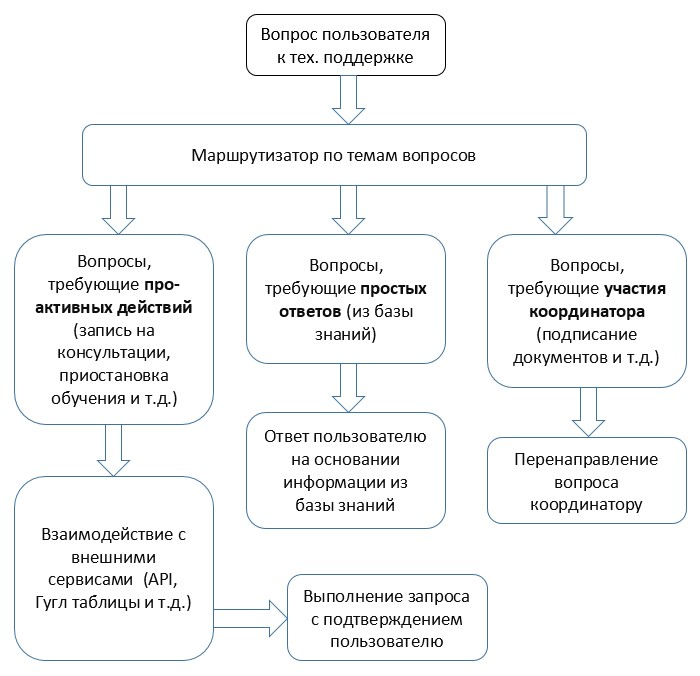

In [ ]:
#@title I. Библиотеки

!pip install -q openai==1.59.9 langchain==0.3.16 langchain_community==0.3.16
!pip install -q langchain_openai==0.3.3 langchain_core==0.3.34 faiss-cpu==1.9.0.post1

from urllib.parse import urlencode
import hmac
import hashlib

from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from google.colab import userdata, drive
from pprint import pprint as pp
from IPython.display import clear_output
from googleapiclient.discovery import build
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
import requests
import textwrap
import openai
import gdown
import json
import time
import os
import re

# Ключ OpenAI
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# Подключаем ГуглДиск для работы с файлами
drive.mount('/content/drive')
# Формируем основной путь
path = '/content/drive/MyDrive/data/tech_support/'
os.makedirs(path, exist_ok=True)

# для обработки Гугл таблиц
google_service_file = os.path.join(path, 'proj-202406.json') # json файл для доступа к гугл таблицам
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = google_service_file

# Cоздание или очистка файла логов
open(os.path.join(path, '_log.txt'), 'w').close()
clear_output() # очистка вывода

# Словарь для учета количества токенов и стоимости
TOKENS = {'price': 0.,
          'input': 0.,
          'output': 0.,
          'total': 0.}

In [ ]:
#@title II. Блок базовых функций

# преобразование строки в Python код
def try_eval(func_text):
    try: return eval(func_text)
    except Exception as ex:
        print(f'Error eval(): {ex}')
        try_eval(func_text)


# Функция преобразования текста в список строк
def text_to_list_lines(text):
    # список по разделителю переноса строки и без пустых строк
    return [line for line in text.split("\n") if line.strip() != '']


# Функция для форматирования текста
def format_text(text, width=120):
    try:
        return '\n'.join(textwrap.fill(line, width) for line in str(text).split('\n'))
    except Exception as ex:
        return f'Error format_text(): {ex}'


# Загрузка фала из GoogleDisk по открытой ссылке
def download_from_google_disk(link, output_path):
    # Идентификатор файла - это последовательность из 25 или более символов (букв, цифр, подчеркиваний, дефисов)
    id = re.findall(r'/d/([a-zA-Z0-9_-]{25,})', link)  # Находим идентификатор файла в ссылке
    direct_link = f'https://drive.google.com/uc?export=download&id={id[0]}'  # Формируем прямую ссылку
    add_log_file(direct_link, title='direct_link')
    gdown.download(direct_link, output_path, quiet=True)


# Функция записи логов в файл _log.txt
def add_log_file(text, title=''):
    time_now = f"{datetime.now().strftime('%Y-%m-%d %H:%M')}"
    with open(os.path.join(path, '_log.txt'), "a", encoding='utf-8') as file:
            file.write(f'\n\n{time_now}. {title}.\n\n{format_text(text)}')


# Очистка файла логов
def clear_log():
    open(os.path.join(path, '_log.txt'), 'w').close()


# Функция подсчета количества используемых токенов и стоимость
# https://openai.com/pricing
def tokens_count_and_price(completion, model, to_print=False):
    if model == "gpt-4o":
        # gpt-4o - Input: $5 / 1M tokens - Output: $15 / 1M tokens
        input_price, output_price = 5, 15
    if model == "gpt-4o-mini":
        # gpt-4o-mini - Input: $0.15 / 1M tokens - Output: $0.60 / 1M tokens
        input_price, output_price = 0.15, 0.60
    # цена запроса
    price = input_price * completion.usage.prompt_tokens / 1e6 + \
            output_price * completion.usage.completion_tokens / 1e6
    # словарь значений (для удобства)
    values = {'price': price,
              'input': completion.usage.prompt_tokens,
              'output': completion.usage.completion_tokens,
              'total': completion.usage.total_tokens}
    if to_print: # вывод информации о к-ве токенов и цене по текущему запросу
        print(f"Tokens used: {values['input']} + {values['output']} = {values['total']}. "
              f"*** {model} *** $ {round(price, 5)}")
    global TOKENS
    for key in TOKENS.keys():
        TOKENS[key] += values[key] # суммируем токены и стоимость


# Вывод информации о накопленном к-ве токенов и стоимости
def print_tokens_info():
    global TOKENS
    print(f"\nTokens used: {TOKENS['input']} + {TOKENS['output']} = {TOKENS['total']} "
          f"*** $ {round(TOKENS['price'], 5)}")


# Функция генерации ответа от OpenAI
def generate_answer(prompt_system, prompt_user, prompt_assistant='', model='gpt-4o-mini', temp=0.):
    messages = [
        {"role": "system", "content": prompt_system},
        {'role': 'assistant', 'content': prompt_assistant},
        {"role": "user", "content": prompt_user}]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp)
    # Вывод количества используемых токенов и стоимость
    tokens_count_and_price(response, model=model)
    add_log_file(response.choices[0].message.content, title='generate_answer()')
    return response.choices[0].message.content


# Создание векторной базы из текстового файла с Markdown разметкой
def split_markdown_text(markdown_file,
                        strip_headers=False): # НЕ удалять заголовки под '#..' из page_content
    # Открываем и читаем содержимое Markdown файла
    with open(markdown_file, 'r', encoding='utf-8') as f:
        markdown_text = f.read()
    # Удалить пустые строки и лишние пробелы
    markdown_text = re.sub(r' {1,}', ' ', re.sub(r'\n\s*\n', '\n', markdown_text))
    # Определяем заголовки, по которым будем разбивать текст
    headers_to_split_on = [("#", "Header 1"),   # Заголовок первого уровня
                           ("##", "Header 2"),  # Заголовок второго уровня
                           ("###", "Header 3")] # Заголовок третьего уровня
    # Создаем экземпляр MarkdownHeaderTextSplitter с заданными заголовками
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on,
                                                   strip_headers=strip_headers)
    # Разбиваем текст на чанки в формат LangChain Document
    chunks = markdown_splitter.split_text(markdown_text)
    # Создаем и возвращаем векторную базу данных FAISS
    return FAISS.from_documents(chunks, OpenAIEmbeddings())


def similarity_info(question, db, k=3):
    # нахождение наиболее похожих документов на основе заданного вопроса
    docs = db.similarity_search(question, k=k)
    # из списока объектов базы знаний docs, извлекаем атрибуты page_content (содержание документов) из каждого docs,
    # добавляем заголовок с форматом '\nChank {i+1}:\n' и объединяем их в строку
    info = '\n'.join([f'\nChank {i+1}:\n' + doc.page_content for i, doc in enumerate(docs)])
    add_log_file(info, title='similarity_info()')
    return info


# Функция ответа на вопрос из баз знаний
def answer_db(question, db_uai, db_add, model='gpt-4o-mini'):
    doc_1 = similarity_info(question, db_uai, k=1)
    doc_2 = similarity_info(question, db_add, k=1)
    system_prompt = """Ты являешься сотрудником техподдержки Университета искусственного
    интеллекта. Ты отвечаешь на вопросы студентов, осуществляешь координаторские функции и помогаешь
    студентам в любых вопросах, связанных с процессом обучения и взаимодействия с Университетом.
    """
    user_prompt = f"""
    Вот информация из дополнительной базы знаний: {doc_2}.
    Вот информация из базы знаний Университета: {doc_1}.
    Вот вопрос студента: {question}.
    Ответь на вопрос студента на основании информации из баз знаний. Не придумывай ничего от себя.
    Выводи ответ в красиво форматированном виде с длинной строки не более 100 символов.
    """
    return generate_answer(system_prompt, user_prompt, model=model)


# Функция диалога (вопрос-ответ) и история диалога
def simple_dialog(questions: list) -> str:
    dialog = '\nОтветьте на уточняющие вопросы, пожалуйста:'
    print(dialog, '\n')
    for i, question in enumerate(questions, 1):
        formatted_question = format_text(f"{question}")
        print(formatted_question, '\n')
        answer = input("Ответ: ")
        print()
        dialog += f"Техподдержка: {formatted_question}\n\nСтудент: {answer}\n\n" # накапливаем историю диалога
    return dialog

In [ ]:
#@title III. Блок функций взаимодействия с Google Таблицами

service = build('sheets', 'v4') # from googleapiclient.discovery
# Для доступа к таблицам через gspread
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
client_gspread = gspread.authorize(
                 ServiceAccountCredentials.from_json_keyfile_name(google_service_file, scope))

# **************************************************************************************************
# Запись и отмена записи на консультации

# Гугл таблица записей на консультации
link_tab = 'https://docs.google.com/spreadsheets/d/1rTsRErKwX_-lSYCOOq0O0uS3My5S9uF8l0DUQeUabi4/edit'
spreadsheet_id = link_tab.split('/')[-2]

# Словарь слотов времени к именам ячеек
time_slots = {'10:00': 'A2',
              '11:00': 'A3',
              '12:00': 'A4',
              '13:00': 'A5',
              '14:00': 'A6',
              '15:00': 'A7',
              '16:00': 'A8',
              '17:00': 'A9',
              '18:00': 'A10'}


# Проверка свободных слотов времени на выбранную дату
def check_free_time_slots(sheet_name: str):
    service_google = build('sheets', 'v4') # from googleapiclient.discovery
    # sheet_name: str - имя листа таблицы (у нас имя листа - эта дата)
    range_ = f'{sheet_name}!A2:A10' # лист и столбец слотов времени
    response = service.spreadsheets().get(spreadsheetId=spreadsheet_id,
                                        ranges=range_,
                                        includeGridData=True).execute()
    free_time_slots = []
    for cell in response['sheets'][0]['data'][0]['rowData']:
        # Если ячейка не закрашена
        if cell['values'][0]['effectiveFormat']['backgroundColor']['red'] == 1:
            free_time_slots.append(cell['values'][0]['formattedValue'])
    if free_time_slots:
        return {f'{sheet_name}': free_time_slots}
    else:
        return None


# Получение id листа Гугл таблицы по его имени
def get_sheet_id(sheet_name):
    spreadsheet = service.spreadsheets().get(spreadsheetId=spreadsheet_id).execute()
    sheet_index = None
    for sheet in spreadsheet['sheets']:
        if sheet['properties']['title'] == sheet_name:
            sheet_id = sheet['properties']['sheetId']
            break
    return sheet_id


# Раскраска ячеек слотов времени (при бронировании).
# Только для ячеек времени в диапазоне от А2 до А10 !!!
def paint_cell(one_cell, sheet_name, colored=True):
    sheet_id = get_sheet_id(sheet_name) # id листа таблицы по его имени
    number = int(one_cell[1:]) # номер ячейки А
    if colored: # закраска
        background_color = {'red': 0.8784314, 'green': 0.4, 'blue': 0.4}
    else: # белый цвет
        background_color = {'red': 1, 'green': 1, 'blue': 1}
    # Запрос к Google Sheets API для закрашивания ячейки
    request = {"updateCells": {"rows": [{"values": [
                {"userEnteredFormat": {"backgroundColor": background_color}}]}],
              "fields": "userEnteredFormat.backgroundColor",
              # для раскраски ячейки обращение только по индексу
              "start": {"sheetId": sheet_id,    # id листа
                        "rowIndex": number - 1, # Индекс строки
                        "columnIndex": 0}}}     # Индекс столбца (A)
    return service.spreadsheets().batchUpdate(
                    spreadsheetId=spreadsheet_id,
                    body={"requests": [request]}).execute()


# Проверка свободных слотов времени для консультации из Гугл таблицы
def check_time_slot(order_dict):
    sheet_name = order_dict['date']
    time_slot = order_dict['time']
    # Проверяем, свободен ли каждый временной слот в Гугл Таблице
    slot_free = True # начальное значение
    try:
        # Имя листа таблицы и имя ячейки слота времени (A..)
        range_ = f'{sheet_name}!{time_slots[time_slot]}'
    except: return None

    # Запрос к Google Sheets API для получения информации
    response = service.spreadsheets().get(
                        spreadsheetId=spreadsheet_id,
                        ranges=range_,
                        includeGridData=True).execute()
    color = response['sheets'][0]['data'][0]['rowData'][0]['values'][0]['effectiveFormat']['backgroundColor']
    # если ячейка закрашена, значит временной слот занят
    if color['red'] != 1: slot_free = False
    return time_slot if slot_free else None


# Запись консультации в Гугл таблицу
def book_slots_time(order_dict, slot):
    sheet_name = order_dict['date']
    if slot:
        paint_cell(time_slots[slot], sheet_name, colored=True) # закраска временных слотов
        number = int(time_slots[slot][1:]) # номер строки из слота времени
        # Имя листа таблицы и ячейки от B.. до Е.. в одной строке
        range_ = f'{sheet_name}!B{number}:E{number}'
        # данные для записи в таблицу
        request_body = {'values': [[str(order_dict['student_id']),
                                        order_dict['student_name'],
                                        order_dict['topic'],
                                        order_dict['course_title']]]}
        response = service.spreadsheets().values().update(
                            spreadsheetId=spreadsheet_id,
                            range=range_,
                            valueInputOption='RAW',
                            body=request_body).execute()


# Проверка существующих записей в таблице по id студента
def check_records(student_id) -> list:
    spreadsheet = client_gspread.open_by_url(link_tab)
    student_records = []
    # по всем листам (вкладкам) таблицы
    for worksheet in spreadsheet.worksheets():
        # все student_id в колонке B
        column_b = worksheet.col_values(2)
        # номера строк с нужным studen_id в колонке B
        rows_with_student_id = [row for row, value in enumerate(column_b) if value == str(student_id)]
        for row in rows_with_student_id:
            student_records.append([worksheet.title] + worksheet.row_values(row + 1))
    return student_records


# Удаление записей на консультацию из таблицы
def clear_record(order: dict, records: list):
    # order: dict - ордер на удаление записи
    # records: list - список существующих записей студента
    sheet_name = order['date']
    time_slot = order['time']
    # пробегаем по существующим записям консультаций
    for record in records:
        # если дата в ордере на удаление равна дате в существующей записи
        if sheet_name == record[0]:
            # если время существующей записи есть в списке слотов на удаление
            if record[1] == time_slot:
                slot = time_slots[record[1]] # ячейка слота времени А..
                number = int(slot[1:]) # номер строки
                paint_cell(slot, record[0], colored=False) # Убираем закраску ячейки
                # Имя листа таблицы и ячейки от B.. до Е.. в одной строке
                range_ = f'{record[0]}!B{number}:E{number}'
                # очистка строки
                response = service.spreadsheets().values().clear(
                                    spreadsheetId=spreadsheet_id,
                                    range=range_).execute()


# Функция согласования времени для записи на консультацию
def check_free_time(dialog: str, formated_date: str, model='gpt-4o-mini') -> str:
    # dialog: str
    # formated_date: str - формат: yyyy-mm-dd
    free_time_slots = check_free_time_slots(formated_date) # вывод свободных слотов времени на дату
    system_prompt = "Ты согласовываешь со студентом время проведения консультации"
    user_prompt = f""": Вот свободные слоты по времени с интервалом в 60 мин. в виде
    {{'дата': [список свободных временных слотов]}}: {free_time_slots}\n
    Здесь история диалога: {dialog}\n
    Если студент не указал год, используй год от текущей даты: {datetime.now().strftime("%Y-%m-%d")}.
    - Проанализируй историю диалога.
    - Проверь желаемое время начала консультации, указанное студентом.
    - Если есть свободные слоты, сообщи студенту о возможности записи на время свободных слотов.
    Попроси подтвердить дату и время начала консультации.
    - Если желаемого времени нет, предложи свободные слоты для записи на эту дату."""
    return generate_answer(system_prompt, user_prompt, model=model)


# Функция вывода существующих записей на консультацию
def existing_records(student_id, model='gpt-4o-mini'):
    status = check_records(student_id) # существующие записи на консультации
    user_prompt = f"""
    Существующие записи на консультацию студента храниться в формате:
    [['дата консультации (yyyy-mm-dd)',
      'время консультации (HH:MM)', 'id студента', 'имя студента',
      'тема консультации (номер урока, этапы диплома и т.д.)'
      'название учебного курса, в рамках которого была консультация'], ...]
    Существующие записи на консультацию студента находится здесь: \n{status}
    Выведи сообщение студенту о его существующих записях без указания 'id студента'.
    Если записей нет, сообщи студенту, что у него нет записей на консультации."""
    return generate_answer('', user_prompt, model=model)


# **************************************************************************************************
# Получение материалов к Вебинарам

# Гугл таблица вебинаров
webinars_link_tab = 'https://docs.google.com/spreadsheets/d/1AtPhTDTpPPfn8udAXZlaHdrFsAaqUJKs7krGSQu6_Nc/edit'
spreadsheet_webinars = client_gspread.open_by_url(webinars_link_tab)


# Функция вывода столбца описания 'F' из таблице вебинаров
def webinars_all_records(col_number=6, webinars_link_tab=webinars_link_tab) -> list:
    worksheet = spreadsheet_webinars.get_worksheet(0)  # доступ к первому листу
    column_f = worksheet.col_values(col_number) # список из 6-го столбеца F
    return [(el, i + 1) for i, el in enumerate(column_f)][1:] # [(название, номер строки),...]


# Функция вывода ссылок на материалы вебинаров по указанным номерам строк таблицы
def find_rows_records(rows_number: list, webinars_link_tab=webinars_link_tab) -> list:
    worksheet = spreadsheet_webinars.get_worksheet(0) # доступ к первому листу
    return [worksheet.row_values(row) for row in rows_number] # строки по заданным номерам


# Находим нужные номера строк запрашиваемых вебинаров в таблице
def get_webinars_row(order, model='gpt-4o-mini') -> list:
    webinars = webinars_all_records() # все описания (только столбец 'F')
    prompt_user = f"""
    # Из ордера на получение данных возьми только дату (если есть) и название вебинара:
    {{'date': 'дата вебинара', 'title': 'название вебинара'}}
    Вот ордер на получение данных: {order}
    # Информация о вебинарах храниться в базе в формате:
    [('дата и название вебинара', номер строки), ...]
    Вот база с информацией о вебинарах: {webinars}
    # Из ордера на получение данных определи вебинар из базы, который нужен (по названию).
    Название вебинара в ордере может не точно соответсвовать его названию в базе.
    Выведи список с номером или номерами строк из базы, соответсвующим запрашиваемым вебинарам.
    Не выводи ничего лишнего. Выведи только список с номером или номерами строк в скобках: [...]"""
    return try_eval(generate_answer('', prompt_user, model=model))


# Вывод ссылок на материалы вебинара из списка в читабельном виде
def webinars_links(rows_number: list, model='gpt-4o-mini') -> str:
    rows_records = find_rows_records(rows_number) # строки из таблицы с нужными ссылками
    prompt_user = f"""Список ссылок на материалы к вебинарам имеет вид:
    [[ссылка на презентацию к вебинару,
      ссылка на Google Colab к вебинару,
      ссылка на видео к вебинару,
      видео ВК,
      ссылка на другие материалы,
      название вебинара,
      дата,
      описание], ...]
    Вот список ссылок на материалы к вебинарам: {rows_records}
    Некоторые элементы списка могут быть пустыми.
    Выведи список ссылок на материалы к запрашиваемым вебинарам."""
    return generate_answer('', prompt_user, model=model)


# **************************************************************************************************
# Запись вопросов к координаторам

# Гугл таблица вопросов координаторам
coordinators_link_tab = 'https://docs.google.com/spreadsheets/d/15xrZZpT3YyNZvz80LaRd3RliTSljiUuZCNL46gWhEd0/edit'

# Запись вопроса координаторам в таблицу
def record_question(student_id, name, question):
    spreadsheet = client_gspread.open_by_url(coordinators_link_tab)
    worksheet = spreadsheet.get_worksheet(0)  # доступ к первому листу
    date_time = datetime.now().strftime("%Y-%m-%d %H:%M")
    # Данные для записи
    data = [date_time, student_id, name, question]
    # Запись строки в конец листа
    worksheet.append_row(data, value_input_option='USER_ENTERED')

In [ ]:
#@title IV. Блок функций обращений к API базы данных УИИ. (Корректный base_url не предоставляется)

# Class UAI_API ************************************************************************************
class UAI_API:
    def __init__(self, student_id: int, secret_key=None):
        self.base_url = 'https:// ... /api' # Ссылка для подключения к базе данных
        self.student_id = student_id
        self.secret_key = secret_key


    # Функция создает цифровую подпись для переданных параметров с использованием
    # ключа secret_key и алгоритма хеширования SHA256
    # (в данной версии взаимодействия с API не используется)
    def gen_signature(self, params):
        return hmac.new(self.secret_key.encode('utf-8'),
                        urlencode(params).encode('utf-8'),
                        hashlib.sha256).hexdigest()


    # Базовая функция обращения к API
    def base_request(self, method, endpoint, params, sign=False):
        header = {}
        if sign:
            params['signature'] = self.gen_signature(params)
        try: # запросы по типам методов
            if method == "GET":
                response = requests.get(url=self.base_url + endpoint, params=params)
            if method == "POST":
                response = requests.post(url=self.base_url + endpoint, json=params)
            if method == "DELETE":
                response = requests.delete(url=self.base_url + endpoint, json=params)

            if not response.text: # Если пустой ответ
                return None
            else:
                return response.json()
        except Exception as ex:
            print((f'Error base_request(): {ex}\n'))


    # Получение всех учебных программ, имеющихся у студента в кабинете
    def get_learning_programms(self) -> list:
        learning_programms = []
        method = 'GET'
        endpoint = '/v2/learning_programms'
        params = {'student': self.student_id}
        programms = self.base_request(method, endpoint, params)
        for program in programms['hydra:member']:
            learning_programms.append((program['id'], program['displayName']))
        return learning_programms # [('id', 'name'), ...]


    # Получение списка учебных программ по типам, имеющихся у студента в кабинете
    def get_learning_programms_by_type(self, n_type: int) -> list:
        # n_type: int - номер типа учебной программы
            # LEARN - 1
            # BONUS - 2
            # DIPLOMA - 3
            # INTERNSHIP - 4
        learning_programms = []
        method = 'GET'
        endpoint = '/v2/learning_programms'
        params = {'student': self.student_id,
                  'type': n_type}
        programms = self.base_request(method, endpoint, params)
        for program in programms['hydra:member']:
            learning_programms.append((program['id'], program['displayName']))
        return learning_programms # [('id', 'name'), ...]


    # Сколько консультаций доступно студенту
    def get_consult_count(self) -> int:
        method = 'GET'
        endpoint = '/v1/consult/count'
        params = {'studentId': self.student_id}
        return self.base_request(method, endpoint, params)['count']


    # Список запланированных консультаций студента
    def get_consult_plan(self, date_start: str):
        method = 'GET'
        endpoint = '/v2/consults'
        params = {'student': self.student_id,
                  'startAt[after]': date_start}
        return self.base_request(method, endpoint, params)['hydra:member']


    # Сколько доступных дней заморозки у студента
    def get_frozen_days_left(self, lpId: int) -> int:
        # lpId: int - код учебного курса
        method = 'GET'
        endpoint = '/v1/learning-program-frozen/left'
        params = {'lpId': lpId,
                  'studentId': self.student_id}
        try:
            return self.base_request(method, endpoint, params)['count']
        except Exception as ex:
            print(f'Error get_frozen_days_left(): {ex}')
            return 0


    # Заморозка обучения
    def post_frozen(self, lpId: int, date_from: str, date_to: str):
        # lpId: int - код учебного курса
        # date_from: str - дата начала заморозки в формате: yyyy-mm-dd
        # date_to: str - дата окончания заморозки в формате: yyyy-mm-dd
        method = 'POST'
        endpoint = '/v1/learning-program-frozen'
        params = {"lpId": lpId,
                  "studentId": self.student_id,
                  "periodFrom": date_from,
                  "periodTo": date_to}
        return self.base_request(method, endpoint, params)


    # Завершить заморозку с указанной даты
    def post_frozen_finish(self, lpId: int, date: str):
        # lpId: int - код учебного курса
        # date_to: str - дата окончания заморозки в формате: yyyy-mm-dd
        method = 'POST'
        endpoint = '/v1/learning-program-frozen/close'
        params = {"lpId": lpId,
                  "studentId": self.student_id,
                  "periodTo": date}
        return self.base_request(method, endpoint, params)


    # Заморозки студента по курсу
    def get_frozens(self, lpId: int):
        # lpId: int - код учебного курса
        method = 'GET'
        endpoint = '/v2/learning_program_frozens'
        params = {'learningProgram': lpId,
                  'studentId': self.student_id}
        return self.base_request(method, endpoint, params)['hydra:member']


    # Сколько осталось дней кураторской поддержки к курсу
    def get_support_days(self, lpId: int) -> int:
        # lpId: int - код учебного курса
        method = 'GET'
        endpoint = f'/v1/learning-program/{lpId}/curator-support'
        params = {"studentId": self.student_id}
        return self.base_request(method, endpoint, params)['curatorSupportDays']


    # Установить дни кураторской поддержки к курсу
    def post_support_days(self, lpId: int, support_days: int) -> bool:
        # lpId: int - код учебного курса
        method = 'POST'
        endpoint = f'/v1/learning-program/{lpId}/curator-support'
        params = {"studentId": self.student_id,
                  "lphlId": lpId,
                  "curatorSupportDays": support_days}
        return self.base_request(method, endpoint, params)['success']


    # Открыть следующее занятие к курсу
    def post_lesson_open(self, lpId: int):
        # lpId: int - код учебного курса
        method = 'POST'
        endpoint = f'/v1/learning-program/{lpId}/lesson-open'
        params = {"studentId": self.student_id,
                  "lphlId": lpId}
        return self.base_request(method, endpoint, params)


    # Начатые дипломные проекты студента
    def get_diploma_started(self):
        method = 'GET'
        endpoint = '/v1/learning-program/diploma/started'
        params = {"studentId": self.student_id}
        return self.base_request(method, endpoint, params)


    # Удалить заморозку по id
    def delete_freezing(self, id: int):
        # id - id заморозки
        method = 'DELETE'
        endpoint = f'/v2/learning_program_frozens/{id}'
        params = {'studentId': self.student_id}
        return self.base_request(method, endpoint, params)


    # Все заморозки студента
    def get_all_frozens(self):
        name_courses = self.get_learning_programms()
        frozens = []
        method = 'GET'
        endpoint = '/v2/learning_program_frozens'
        params = {'learningProgram.student': self.student_id}
        items =  self.base_request(method, endpoint, params)['hydra:member']
        for item in items:
            pid = int(item['learningProgram'].split('/')[-1]) # id учебной программы
            for course in name_courses: # по всем курсам студента
                if int(course[0]) == pid: # если совпадают id учебных курсов
                    frozens.append((item['id'], # id заморозки
                                    pid,  # id учебной программы
                                    course[1], # наименование учебной программы
                                    item['periodFrom'][:10], # дата - с какого числа
                                    item['periodTo'][:10]))  # дата - по какое число
        return frozens

# **************************************************************************************************

# Вопрос студенту для подтверждения названия учебного курса
def get_name_course(dialog, model='gpt-4o-mini') -> str:
    courses = api_client.get_learning_programms_by_type(n_type=1) # учебные курсы студента
    prompt_user = f"""# Список курсов имеет вид:
    [(id учебного курса, название учебного курса), ...]
    Здесь список курсов: {courses}
    # Здесь диалог со студентом: {dialog}
    В диалоге студент указал название нужного курса.
    # Название курса из диалога может не соответсвовать его точному названию в списке курсов.
    Найди нужный или нужные курсы из списка курсов с id и попроси студента подтвердить, верно ли выбраны курсы.
    Если курсов с похожим названием несколько, попроси студента написать точное название курса, можно
    скопировать вместе с id из выведенных выше вариантов"""
    return generate_answer('', prompt_user, model=model)


# Python список курсов студента
def get_name_courses_list(dialog, model='gpt-4o-mini') -> str:
    courses = api_client.get_learning_programms_by_type(1)
    prompt_user = f"""# Список курсов имеет вид:
    [(код учебного курса, название учебного курса), ...]
    Здесь список курсов: {courses}
    # Здесь диалог со студентом: {dialog}
    В диалоге студент указал название нужного курса.
    # Название курса из диалога может не соответсвовать его точному названию в списке курсов.
    Найди нужный или нужные курсы из списка курсов в соответствии с требованием студента и
    выведи их формате списка:
    [(код учебного курса, название учебного курса в соответствии с требованием студента ), ...]
    Не выводи ничего личнего. Выведи только список. Запрещаю в ответе вывод кода: ```python """
    cources = generate_answer('', prompt_user, model=model)
    # дополнительный контроль вывода через регулярные выражения - только список Python
    return eval(re.search(r'(\[.*\])', cources).group(1))


# Информация о всех заморозках студента в чат
def get_frozens(model='gpt-4o-mini') -> str:
    frozens = api_client.get_all_frozens()
    prompt_user = f"""# Список заморозок (приостановок обучения) имеет вид:
        [(id заморозки,
        id учебного курса,
        название учебного курса,
        дата начала заморозки,
        дата конца заморозки), ...]
    Здесь список заморозок студента: {frozens}.
    Если список заморозок пустой, сообщи, что приостановок в обучении не было.
    Выведи в форматированном удобочитаемом виде все заморозки из списка БЕЗ поля id заморозки:
    id учебного курса, название учебного курса, дата начала заморозки, дата конца заморозки.
    Не выводи ничего лишнего и ничего не придумывай от себя."""
    return generate_answer('', prompt_user, model=model)


# заморозка и подтверждение
def freezing_confirmation(title, date_start, date_end, model='gpt-4o-mini'):
    start = datetime.strptime(date_start, "%Y-%m-%d")
    end = datetime.strptime(date_end, "%Y-%m-%d")

    courses = get_name_courses_list(f'Курс: {title}') # Подбор курсов в кабинете по названию от студента
    confirmation = ''
    for course in courses:
        plid = int(course[0])
        title = course[1]

        days_left = api_client.get_frozen_days_left(plid) # начальный остаток дней заморозки
        if days_left == 0:
            confirmation += f'\nУ вас закончились дни для приостановки обучения по курсу {title} (id: {plid})'
            return
        if (end - start).days > days_left: # превышение дней заморозки
            confirmation += '\n\n' + re.sub(r"\s+", " ", f"""Курс: {title} (id: {plid}).
            Количество дней, на которое вы хотите приостановить обучение: {(end - start).days},
            но, возможное количество дней, которое у вас осталось для заморозки: {days_left}.
            Оформляю приостановку на доступное количество дней.""")
            date_end = (start + timedelta(days=days_left)).strftime("%Y-%m-%d") # новая конечная дата заморозки

        api_client.post_frozen(plid, date_start, date_end) # заморозка
        days_left = api_client.get_frozen_days_left(plid) # текущий остаток дней заморозки
        confirmation += f'\n\nОбучение по курсу {title} (id: {plid}) приостановлено с {date_start} по {date_end}.'
        confirmation += f'\nОставшееся количество дней для возможных приостановок: {days_left}.'
        # frozen = api_client.get_frozens(plid) # Информация о заморозке
        # pp(frozen)
    return confirmation


# Разморозка и подтверждение
def defrost_confirmation(title, date, model='gpt-4o-mini'):
    courses = get_name_courses_list(f'Курс: {title}') # Подбор курсов в кабинете по названию от студента
    confirmation = ''
    for course in courses:
        plid = int(course[0])
        title = course[1]
        try:
            date_start = api_client.get_frozens(plid)[-1]['periodFrom'][:10] # дата начала существующей заморозки
            start = datetime.strptime(date_start, "%Y-%m-%d")
            order = datetime.strptime(date, "%Y-%m-%d") # желаемая дата продолжения обучения
            if (order - start).days < 1: # отмена не ранее следующего дня за началом существующей приостановки
                date = (start + timedelta(days=1)).strftime("%Y-%m-%d") # новая дата продолжения обучения
                confirmation += '\nПродолжение обучения возможно не ранее следующего дня после даты начала существующей приостановки.'

            api_client.post_frozen_finish(plid, date) # снятие заморозки
            days_left = api_client.get_frozen_days_left(plid) # текущий остаток дней заморозки
            confirmation += f'\n\nОбучение по курсу {title} (id: {plid}) приостановлено с {date_start} до {date}.'
            confirmation += f'\nОставшееся количество дней для возможных приостановок: {days_left}.'
            # frozen = api_client.get_frozens(plid) # Информация о заморозке
            # pp(frozen)
        except: pass
    return confirmation if confirmation else '\nУ вас нет приостановок по указанному курсу'


# Добавляем дни на этапы дипломного проекта
def add_support_days_diplom(days=60):
    diploma_started = api_client.get_diploma_started()
    if diploma_started: # Если есть открытые дипломные проекты
        for key in diploma_started.keys(): # пробегаем по все проектам, если несколько
            diplom = diploma_started[key]
            # pp(diplom)
            print()
            print(f"Дипломный проект: {diplom['name']}")
            if diplom['curatorSupportDays'] < 5: # Если остаток дней менее 5
                api_client.post_support_days(diplom['id'], days) # добавляем 60 дней
            print(f"Вы имеете дни кураторской поддежки в количестве: {diplom['curatorSupportDays']}.")
    else: print('У вас нет открытых дипломных проектов')


In [ ]:
#@title V. Блок функций диалогов и формирования ордеров

# Повторяющиеся Шаблоны базовых промптов
SYSTEM_MAIN = re.sub(r"\s+", " ", """
Ты являешься сотрудником техподдержки УИИ.
Не нужно здороваться, ты уже поздоровался.
Не упоминай в своих сообщениях об истории диалога.""")
USER_MAIN = ''
LAST_INSTRUCTION = re.sub(r"\s+", " ", """
# Если студент отвечает не по теме нужных вопросов, попроси его ответить по теме.
# Затем, ОБЯЗАТЕЛЬНО проведи проверку, ты должен вывести полученную информацию от студента из истории
диалога и попросить студента подтвердить, все ли верно?""")


# Функция остановки диалога со стороны тех. поддержки
def tech_stop_dialog(dialog, model='gpt-4o-mini'):
    user_prompt = f"""Вот история диалога: {dialog}.
    # Если студент в последнем ответе на вопрос: 'все ли верно?' из истории диалога подтвердил,
    что все верно (например: верно, правильно, ок, да, или другими утвердительными выражениями),
    выведи код: *stop*
    # Если студент НЕ подтвердил, что все верно, выведи код: *continue*
    # Не выводи ничего лишнего, только один код: *stop* или *continue* """
    # запрос к OpenAI
    return generate_answer('Ты останавливаешь или продолжаешь диалог', user_prompt, model=model)


# Функция Базовой модели выявление потребности студента
def basic_model(dialog,                 # начальный диалог или первый вопрос студента
                add_system_prompt,      # доп. системный промпт
                add_user_prompt,        # доп. промпт на выявление конкретных потребностей
                user_main=USER_MAIN,
                last_instruction=LAST_INSTRUCTION,
                model='gpt-4o-mini'):
    system_prompt = f'{SYSTEM_MAIN} \n{add_system_prompt}'
    while True:
        user_prompt = f"""Здесь история диалога: {dialog}.
        #1. {user_main}
        #2. {add_user_prompt}
        #3. {last_instruction}"""
        add_log_file(f'{user_prompt}', title='user_prompt')

        # остановка диалога сообщением от тех.поддержки
        tech_stop = tech_stop_dialog(dialog)
        if '*stop*' in tech_stop: break

        # ответ тех. поддержки
        tech_answer = generate_answer(system_prompt, user_prompt, model=model)
        dialog += f'\nТехподдержка: {tech_answer}' # накапливаем историю диалога
        print(format_text(tech_answer), '\n')

        sudent_answer = input("Ваш ответ: ")
        # остановка диалога студентом
        if sudent_answer == 'stop' or sudent_answer == 'стоп': break
        dialog += f'\n\nОтвет студента: {sudent_answer}\n' # ответ студента в историю диалога
        print()
    add_log_file(dialog, title='dialog')
    return dialog


# Функция создания ордера
def create_json(dialog, json_template, model='gpt-4o-mini') -> dict:
    user_prompt_json = f"""Здесь диалог студента со службой техподдержки: {dialog}.
    Найди в диалоге нужную информацию и выведи в формате Json следующие поля: {json_template}
    Не выводи ничего лишнего, не выводи: ```json. Выведи только Json код в скобках"""
    # запрос к OpenAI
    return try_eval(generate_answer('Ты создатель Json объектов', user_prompt_json, model=model))


# Функция выявления потребности студента и формирования Json ордера
# Объединяем в одну две функции, указанные выше
def dialog_and_order(dialog,            # начальный диалог или первый вопрос студента
                     add_system_prompt, # доп. системный промпт
                     add_user_prompt,   # доп. промпт на выявление конкретных потребностей
                     json_template,
                     user_main=USER_MAIN,
                     last_instruction=LAST_INSTRUCTION,
                     model='gpt-4o-mini') -> dict:
    # Диалог по выявлению потребности студента
    dialog = basic_model(dialog,
                         add_system_prompt,
                         add_user_prompt,
                         user_main=user_main,
                         last_instruction=last_instruction,
                         model=model)
    # Формирование Json ордера
    return create_json(dialog, json_template, model=model)


# Функция форматирования введенной даты
def format_date(dialog: str, model='gpt-4o-mini') -> str:
    date_prompt = f"""Здесь история диалога: {dialog}.
    Найди последнюю дату, указанную студентом в диалоге и выведи в виде: yyyy-mm-dd
    Если студент не указал год, используй год от текущей даты: {datetime.now().strftime("%Y-%m-%d")}.
    Не выводи ничего лишнего, выведи только одну дату в виде: yyyy-mm-dd"""
    return generate_answer('Ты форматируешь даты в формат: yyyy-mm-dd', date_prompt, model=model)

# **************************************************************************************************
# Диалоги

# Функция диалога записи на консультацию с подтверждением времени
def consultation(question, student_id, model='gpt-4o-mini'):
    print('Запуск consultation()')
    dialog = f'Студент: {question}' # Начало диалога
    support_questions = ['Укажите желаемую дату и время начала консультации',
                         'Укажите название учебного курса, в рамках которого нужна консультация',
                         'Укажите тему консультации (номер урока, по диплому и т.д.)']
    dialog += simple_dialog(support_questions) # ответы на вопросы техподдержки
    # -------------------------------------------------------------------------
    formated_date = format_date(dialog, model=model) # Форматирование введенной даты
    answer_free_time = check_free_time(dialog, formated_date, model=model) # ответ по свободным слотам
    print(format_text(answer_free_time), '\n')
    dialog += f'\nТехподдержка: {answer_free_time}' # накапливаем историю диалога

    student_answer = input("Ваш ответ: ")
    print()
    student_answer = re.sub(r"\s+", " ", f"""\nВНИМАНИЕ, ВАЖНАЯ ИНФОРМАЦИЯ !!! В ответе студента
    согласование (или пересогласование) времени и/или даты консультации. Использовать согласованное
    время и/или дату. Ответ студента: {student_answer}.""")
    dialog += f'\n{student_answer}\n' # ответ студента в историю диалога
    # ------------------------------------------------------------------
    add_system_prompt = 'Студент хочет записаться на консультацию.'
    add_user_prompt = """
    Обрати внимание в истории диалога на указание: ВНИМАНИЕ, ВАЖНАЯ ИНФОРМАЦИЯ !!!
    Ты должен взять из истории диалога самую последнюю согласованную дату и время консультации,
    повторно согласованную студентом в дополнительном сообщении о выборе времени и/или даты.
    Ты должен вывести всю информацию с последней согласованной датой и временем консультации и
    попросить студента подтвердить, все ли верно. Не спрашивай ничего лишнего."""
    json_template = f"""
    {{'student_id': {student_id},
      'date': 'дата начала консультации (yyyy-mm-dd)',
      'time': 'время начала консультации (hh:mm)',
      'course_title': 'название учебного курса, в рамках которого нужна консультация',
      'topic': 'тема консультации (номер урока, по диплому и т.д.)'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt,
                            json_template, last_instruction='', model=model)


# Функция отмены записи на консультацию
def cancel_consultation(question, student_id, model='gpt-4o-mini'):
    print('Запуск cancel_consultation()\n')
    dialog = f'\nСтудент: {question}' # Начало диалога
    print(re.sub(r"\s+", " ", """Если вы хотите изменить и перенести дату и/или время консультации,
    сначала отмените существующую запись."""), '\n')
    dialog += f'\nПричина отмены студентом: {input("Укажите причину отмены или переноса: ")}\n'
    print()
    # информация о забронированных консультациях студента ----------------------------
    status = check_records(student_id)
    dialog += f"""\nСуществующие записи на консультацию студента храниться в формате:
    [['дата отменяемой консультации (yyyy-mm-dd)',
      'время отменяемой консультации (hh:mm)', 'id студента', 'имя студента',
      'тема консультации (номер урока, этапы диплома и т.д.)'
      'название учебного курса, в рамках которого была консультация'], ...]
    Находится вот здесь: \n{status}"""
    # --------------------------------------------------------
    add_system_prompt = 'Студент хочет отменить консультацию.'
    add_user_prompt = """Из истории диалога найди существующие записи на консультацию студента.
    Студент может отменить только существующую консультацию из истории диалога.
    Выведи информацию о существующих записях на консультацию и ОБЯЗАТЕЛЬНО попроси студента
    ПОДТВЕРДИТЬ, консультацию на какое время и дату отменяет студент, (дату и время отменяемой
    консультации). Не выводи просьбу подтвердить дату и время повторно, если это уже есть в диалоге."""
    json_template = f"""
    {{'student_id': {student_id},
      'date': 'дата отменяемой консультации из диалога и существующей записи (yyyy-mm-dd)',
      'time': 'время отменяемой консультации из диалога и существующей записи (hh:mm)',
      'date_time_now': 'текущая дата и время {datetime.now().strftime("%Y-%m-%d %H:%M")}',
      'course_title': 'название учебного курса, в рамках которого была консультация',
      'topic': 'тема отменяемой консультации (номер урока, этап диплома и т.д.)',
      'reason': 'причина отмены консультации'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция диалога запроса контента по вебинару
def webinar(question, student_id, model='gpt-4o-mini'):
    print('Запуск webinar()\n')
    dialog = f'Студент: {question}' # Начало диалога
    add_system_prompt = 'Студент просит информацию и ссылки на контент по прошедшему вебинару.'
    add_user_prompt = """В истории диалога должна быть следующая информация:
    - дата вебинара (возможно примерная или неполная).
    - название вебинара.
    Если в истории диалога недостаточно информации по двум выше перечисленным пунктам, ты должен
    сообщить студенту о том, какой информации недостаточно и спросить у студента недостающую информацию.
    Информация должна содержать: дату вебинара (можно примерную или неполную); название вебинара."""
    json_template = f"""
    {{'student_id': {student_id},
      'date': 'дата вебинара (возможно примерная или неполная)',
      'title': 'название вебинара'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция диалога запроса прорверки домашнего задания (во 2-й группе)
def check_homework(question, student_id, model='gpt-4o-mini'):
    print('Запуск check_homework()')
    dialog = f'Студент: {question}' # Начало диалога
    add_system_prompt = 'Студент спрашивает о проверке домашних заданий или этапов дипломного проекта'
    add_user_prompt = """В истории диалога должна быть следующая информация:
    - название курса.
    - номер урока или номер этапа дипломного проекта.
    - дополнительные сведения (задание Лайт, Про, название этапа дипломного проекта и др.).
    Если в истории диалога недостаточно информации по трём выше перечисленным пунктам, ты должен
    сообщить студенту о том, какой информации недостаточно и спросить у студента недостающую информацию.
    Информация должна содержать: название курса; номер урока или номер этапа дипломного проекта;
    дополнительные сведения (задание Лайт, Про, название этапа дипломного проекта и др.)"""
    json_template = f"""
    {{'student_id': {student_id},
      'title': 'название курса',
      'item': 'номер урока или номер этапа дипломного проекта',
      'additions': 'дополнительные сведения (задание Лайт, Про, название этапа дипломного проекта и др.)'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция диалога по заморозке обучения
def freezing(question, student_id, model='gpt-4o-mini'):
    print('Запуск freezing()\n')
    dialog = f'Студент: {question}' # Начало диалога

    tech_support = re.sub(r"\s+", " ", """Уточните название курса, по которому хотите приостановить
    (заморозить) обучение, срок приостановки или даты приостановки в интервале с ... по ...""")
    print(format_text(tech_support), '\n')
    dialog += f'Техподдержка: \n{tech_support}\n'

    dialog += f'\nСтудент: {input("Ваш ответ: ")}\n\n'
    correction_title = get_name_course(dialog) # Уточнение (корректировка) названия курса
    print(correction_title, '\n')
    dialog += f'Техподдержка: \n{correction_title}\n'

    add_system_prompt = 'Студент спрашивает о возможности временной приостановки обучения'
    add_user_prompt = """В истории диалога должна быть следующая информация:
    - Название курса, по которому студент хочет временно приостановить (заморозить) обучение.
    - Указание студента, на какой срок приостаналивается (замораживается) обучение или интервал дат.
    Если в истории диалога недостаточно информации по двум выше перечисленным пунктам, ты должен
    сообщить студенту о том, какой информации недостаточно и спросить у студента недостающую информацию.
    Информация должна содержать: Название курса, по которому студент хочет временно приостановить
    (заморозить) обучение; на какой срок приостаналивается (замораживается) обучение."""
    json_template = f"""
    {{'student_id': {student_id},
      'title': 'название курса, по которому студент хочет временно приостановить (заморозить) обучение',
      'date_now': 'текущая дата {datetime.today().strftime("%Y-%m-%d")}',
      'date_start': 'дата в формате yyyy-mm-dd, с которой приостанавливается обучение',
      'date_end': 'дата в формате yyyy-mm-dd, по которую приостаналивается обучение (с учетом срока, указанного студентом)'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция разморозки обучения
def defrost(question, student_id, model='gpt-4o-mini'):
    print('Запуск defrost()')
    dialog = f'Студент: {question}' # Начало диалога

    tech_support = re.sub(r"\s+", " ", """Уточните название курса, по которому хотите продолжить
    (разморозить) обучение и дату, с которой хотите продолжить обучение""")
    print(format_text(tech_support), '\n')
    dialog += f'Техподдержка: \n{tech_support}\n'

    dialog += f'\nСтудент: {input("Ваш ответ: ")}\n\n'
    correction_title = get_name_course(dialog) # Уточнение (корректировка) названия курса
    print(correction_title, '\n')
    dialog += f'Техподдержка: \n{correction_title}\n'

    add_system_prompt = 'Студент хочет продолжить (разморозить) обучение после приостановки (паузы)'
    add_user_prompt = """В истории диалога должна быть следующая информация:
    - Название курса, по которому студент хочет продолжить (разморозить) обучение.
    - С какой даты студент хочет продолжить (разморозить) обучение.
    Если в истории диалога недостаточно информации по двум выше перечисленным пунктам, ты должен
    сообщить студенту о том, какой информации недостаточно и спросить у студента недостающую информацию.
    Информация должна содержать: Название курса, по которому студент хочет продолжить (разморозить) обучение;
    С какой даты студент хочет продолжить (разморозить) обучение."""
    json_template = f"""
    {{'student_id': {student_id},
      'title': 'Название курса, по которому студент хочет продолжить (разморозить) обучение',
      'date_now': 'текущая дата {datetime.today().strftime("%Y-%m-%d")}',
      'date': 'дата в формате yyyy-mm-dd, с какой даты студент хочет продолжить (разморозить) обучение'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция диалога по открытию уроков раньше
def open_lessons(question, student_id, model='gpt-4o-mini'):
    print(f'Запуск open_lessons()')
    dialog = f'Студент: {question}' # Начало диалога
    add_system_prompt = 'Студент просит открыть уроки по курсу раньше срока проведения урока'
    add_user_prompt = """В истории диалога должна быть следующая информация:
    - Название курса, по которому студент хочет открыть урок.
    - номер или номера уроков.
    Если в истории диалога недостаточно информации по двум выше перечисленным пунктам, ты должен
    сообщить студенту о том, какой информации недостаточно и спросить у студента недостающую информацию.
    Информация должна содержать: Название курса, по которому студент хочет открыть урок;
    номер или номера уроков."""
    json_template = f"""
    {{'student_id': {student_id},
      'title': 'Название курса, по которому студент хочет открыть урок',
      'lessons': 'номер или номера уроков'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция переноса начала обучения (в 3-ю группу вопросов)
def change_start_study(question, student_id, model='gpt-4o-mini'):
    print('Запуск change_start_study()')
    dialog = f'Студент: {question}' # Начало диалога
    add_system_prompt = 'Студент хочет перенести срок начала обучения'
    add_user_prompt = """В истории диалога должна быть следующая информация:
    - Название курса, по которому студент хочет сдвинуть срок начала обучения.
    - Новая дата начала обучения по курсу yyyy-mm-dd.
    Если в истории диалога недостаточно информации по двум выше перечисленным пунктам, ты должен
    сообщить студенту о том, какой информации недостаточно и спросить у студента недостающую информацию.
    Информация должна содержать: Название курса, по которому студент хочет перенести срок начала обучения;
    Новая дата начала обучения по курсу yyyy-mm-dd"""
    json_template = f"""
    {{'student_id': {student_id},
      'title': 'Название курса, по которому студент хочет сдвинуть срок начала обучения',
      'date': 'Новая дата начала обучения по курсу (yyyy-mm-dd)'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция диалога по смене персональных данных (в 3-ю группу вопросов)
def change_personal_data(question, student_id, model='gpt-4o-mini'):
    print('Запуск change_personal_data()')
    dialog = f'Студент: {question}' # Начало диалога
    add_system_prompt = """Студент просит изменить email (почту) для доступа к кабинету, или номер
    телефона, или другие персональные данные."""
    add_user_prompt = """В истории диалога должна быть следующая информация:
    - Email студента.
    - Контактный номер телефона студента с кодом страны, например: +7 915 100 00 00.
    - Ссылка на телеграм в формате: https://t.me/...
    Если в истории диалога недостаточно информации по выше указанным трём пунктам, ты должен
    сообщить студенту о том, какой информации недостаточно и спросить у студента недостающую информацию.
    Информация должна содержать: Email студента; Контактный номер телефона студента с кодом страны,
    например: +7 915 100 00 00; Ссылка на телеграм в формате: https://t.me/..."""
    json_template = """
    {{'email': 'Email студента'},
    {'phone_number': 'номер телефона студента с кодом страны, например: +7 915 100 00 00'},
    {'telegram': 'Ссылка на телеграм в формате: https://t.me/...'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция добавления времени поддержки для сдачи этапов дипломного проекта
def add_diplom_time(question, student_id, model='gpt-4o-mini'):
    print('Запуск add_diplom_time()')
    dialog = f'Студент: {question}' # Начало диалога
    add_system_prompt = """Студент хочет продлить (добавить) время кураторской поддержки для сдачи
    этапов дипломного проекта (ДП)."""
    add_user_prompt = """В истории диалога должна быть информация с Названием курса, по которому
    студент делает дипломный проект. Если в истории диалога нет названия курса, ты должен спросить
    у студента название курса, по которому он делает дипломный проект."""
    json_template = f"""
    {{'student_id': {student_id},
      'title': 'Название курса, по которому студент делает дипломный проект'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)


# Функция записи на стажировку (в 3-ю группу вопросов)
def internship(question, student_id, model='gpt-4o-mini'):
    print('Запуск internship()\n')
    dialog = f'Студент: {question}' # Начало диалога
    support = re.sub(r"\s+", " ", """Ознакомьтесь с предстоящими стажировками на странице:
    https://lk.neural-university.ru/announcement""")
    print(format_text(support), '\n')
    support_questions = ['Сообщите название выбранного проекта стажировки',
                         'Сообщите месяц, в котором начинается стажировка']
    dialog += simple_dialog(support_questions) # ответы на вопросы техподдержки
    # -------------------------------------------------------------------------
    add_system_prompt = """Студент хочет записаться на стажировку по проекту."""
    add_user_prompt = """В истории диалога должна быть следующая информация:
    - Название проекта стажировки.
    - Месяц, в котором начинается стажировка.
    Если в истории диалога недостаточно информации по двум выше указанным пунктам, ты должен
    сообщить студенту о том, какой информации недостаточно и спросить у студента недостающую информацию.
    Информация должна содержать: Название проекта стажировки; Месяц, в котором начинается стажировка."""
    json_template = f"""
    {{'student_id': {student_id},
      'title': 'Название проекта стажировки'
      'month': 'Месяц, в котором начинается стажировка.'}}"""
    return dialog_and_order(dialog, add_system_prompt, add_user_prompt, json_template, model=model)

In [ ]:
#@title VI. Блок создания векторных баз

# Создание векторной базы знаний УИИ
uai_data_link = 'https://drive.google.com/file/d/1bKxYzpEGMxCLQ1r83yhUXIfdMt0M2qno/view'
download_from_google_disk(uai_data_link, path)
db_uai = db_from_markdown_file(os.path.join(path, 'main_database.txt'))
db_uai.save_local(folder_path=path, index_name='db_uai')

db_uai = FAISS.load_local(folder_path=path,
                          allow_dangerous_deserialization=True,
                          embeddings=OpenAIEmbeddings(),
                          index_name='db_uai')

# Создание доп. векторной базы вопросов-ответов
add_data_link = 'https://drive.google.com/file/d/1vAETVsNOZW7dgFtDFEzY0KBy-J4wX1t6/view'
download_from_google_disk(add_data_link, path)
db_add = db_from_markdown_file(os.path.join(path, 'add_database.txt'))
db_add.save_local(folder_path=path, index_name='db_add')

db_add = FAISS.load_local(folder_path=path,
                          allow_dangerous_deserialization=True,
                          embeddings=OpenAIEmbeddings(),
                          index_name='db_add')


# Функция ответа из баз знаний
def database(question, studet_id, model='gpt-4o-mini'):
    print(f'Запуск database()\n')
    answer = answer_db(question, db_uai, db_add, model=model)
    return format_text(answer)

In [ ]:
#@title VII. Блок маршрутизации

system_prompt = """Ты являешься сотрудником техподдержки Университета искусственного
интеллекта. Сейчас, ты должен присвоить конкретный единственный код вопросу студента."""

# Вопросы для перенаправления координаторам (3-я категория)
qoestions_coordinator = """
# Выкуп услуг (выкуп стоимости):
У меня есть выкуп стоимости?
Скажите, пожалуйста, по поводу выкупа?
Можете рассказать про выкуп курса, для которого нужно проходить все задания и уроки?
До какого числа мне надо завершить обучение, чтобы трудоустроиться к вам?
К кому обратиться по поводу выкупа обучения?
Не понимаю, какие у меня условия по выкупу стоимости

# Вопросы после осуществления записи или после заполнения формы на стажировку:
Заполнил форму участия в стажировке, подскажите, я в списках?
Я заполнил форму, вы нашли меня в спиках?
Меня не добавили в чат по стажировке и я не получил письма, мой ответ в форму дошел?
Можно добавиться к стажировке на август, я заполнила форму

# Не пришли документы (для подписания):
Добрый день. Я участвую в стажировке и мне не пришли документы на подписание
В чате пишут, что я не подписал документы, но я подписывал
Мне должны были отправить документы по стажировкие, но на почте ничего нет
Добрый день, обещали отправить договор на обучение, ничего нет

# Тема дипломного проекта (ДП), КРОМЕ вопросов записи на консультацию по ДП:
Не могу определиться с темой дипломного проекта, нужна помощь
Я сейчас делаю дипломный проект и застрял на таком моменте ... Мне может кто-то с этим помочь?
Мне нужен куратор, разбирающийся ... для моего дипломного проекта

# Назначение экзамена / защиты дипломного проекта (ДП), запись на защиту или экзамен, КРОМЕ вопросов записи на консультацию:
У меня приняли шестой этап. И следующий этап это защита дипломного проекта. Как организовывается этот момент? Нужно ли мне подавать заявку? Или я сам должен создать созвон?
Прошу, запишите меня на защиту
Доброе утро, хотел бы согласовать дату защиты дипломного проекта, в какие дни и часы она проводится?
Могу я записаться на экзамен, на следующей недели или эти выходные?
Как мне записаться на экзамен?
Готов к экзамену, на какое число можно записаться?

# Закрывающие документы:
Мне нужны закрывающие документы?
Через вас можно оформить закрывающие документы?
Мне нужен акт выполненный услуг
Бухгалтерия просит, чтобы вы сделали акт выполненных услуг
Можете оформить акт выполненных услуг?

# Налоговый вычет:
Добрый день! А я могу получить налоговый вычет за обучение в УИИ?
скажите, пожалуйста, как получить документы для налогового вычета?
хотел бы вернуть 13% налоговый вычет. Могли бы мне в этом помочь?
Возможно ли оформить налоговый вычет на обучение в Вашей организации?
Такой вопрос имеется: есть ли возможность получения налогового вычета за обучение?

# Возврат:
Кстати, я вот хотел бы вернуть деньги. Это можно сделать?
Добрый день, у меня не получается приступить к обучению. Поэтому хочу вернуть деньги
Я прочел договор и не смог понять принципы возврата оплаты в случае, если я не могу по каким то причинам продолжать обучение
На сегодняшний день я не вижу возможности получать оплаченные услуги далее. Предусматривается ли возврат денежных средств за недополученные услуги? Спасибо.
Я хотел бы отменить наш договор и вернуть мои деньги

# Переход из проекта в проект по стажировке, КРОМЕ вопросов записи на стажировку:
Пару дней назад я отправил форму на стажировку (июнь 2024) по chat gpt с выбором проекта, но я хотел бы поменять проект стажировки. Это возможно?
Может мне проект поменять?
Могу я поменять стажировку из gpt на май?
Я хочу поменять проект
У меня прошла только неделя с первого созвона, можно мне поменять проект

# Ошибка в оценке домашнего задания (дз, домашки):
Пришло на почту, что работа/этап принят, но оценка не стоит.

# Вопросы по разработке проектов
У меня есть проект, нужны разработчики
У меня есть проект для стажировки
У меня есть проект нужна ваша помощь
# ----------------------------------------------------------"""

# 1-я категория вопросов
questions_main = """
# 01. Студент хочет получить ссылку на видео с вебинара, или ноутбук (колаб) с вебинара, или
презентацию с вебинара. Вот некоторые примеры запросов по этой теме:
- На прошлой неделе был интенсив по разбору 9 нейронок. Можно получить ссылку на colab?
- Как мне можно  получить доступ к вебинарам, которые прошли 8 и 9 июля в 19-00
- Подскажите, можно ссылку на понедельнишный вебинар и колаб?
- Хочу попросить поделиться  ссылкой на colab и записи вебинара от 23 июля
- Пришлите, пожалуйста, запись вчерашнего вебинара
- Хочу попросить поделиться ссылкой на colab и записи вебинара от 23 июля
- Не могли бы Вы прислать ссылку на вчерашний вебинар и колаб
- Подскажите, можно ссылку на понедельнишный вебинар и колаб?
- Можно получить ноут с прошедшего вебинара
- Хочу попросить поделиться ссылкой на colab и записи вебинара от 23 июля
- А можно получить презентацию с вебинара, который был во вторник?
- Подскажите, где можно найти презентацию с вебинара
- Можно презу с вебинара в прошлый вторник? (преза - это презентация)
- Можете скинуть презентацию с последнего вебинара?
- А где взять презентацию с вебинара вчерашнего?
В этом случае выведи код: webinar

# 02. Студент хочет записаться на любую консультацию, хочет назначить время или дату на консультацию.
Это может быть консультация по любой теме и материалам урока или консультация по дипломному проекту,
этапам и разделам дипломного проекта, или записаться на экзамен, или записаться на защиту дипломного
проекта (ДП). Вот некоторые примеры запросов по этой теме:
- Я хочу назначить консультацию
- Хочу назначить консультацию по теме занятия
- У меня вопрос по уроку, нужна консультация
- Не понимаю занятие, хочу назначить консультацию с куратором
- Мне нужна консультация с куратором, как ее назначить?
- Прошу, запишите меня на защиту (дипломного проекта)
- Доброе утро, хотел бы согласовать дату защиты дипломного проекта, в какие дни и часы она проводится?
- Могу я записаться на экзамен, на следующей недели или эти выходные?
- Как мне записаться на экзамен?
В этом случае выведи код: consultation

# 03. Студент хочет отменить консультацию или изменить (перенести) дату и/или время консультации.
Вот некоторые примеры запросов по этой теме:
- У меня поменялись планы, как отменить консультацию?
- Я не успеваю сегодня присутствовать на консультации, можно ее отменить?
- Я назначил консультацию на четверг, но уже разобрался сам, как ее можно отменить?
- Передумал, мне не нужна консультация, как ее отменить?
- Можно перенести консультацию?
В этом случае выведи код: cancel_consultation

# 04. Студент хочет заморозить (приостановить) обучение на определенный строк.
Вот некоторые примеры запросов по этой теме:
- Прошу приостановить кураторскую поддержку
- Можно приостановить поддержку куратора?
- Мне надо приостановить обучение
- Просьба приостановить поддержку
- как оформить отсрочку по обучению?
- Есть возможность приостановить обучение на время?
В этом случае выведи код: freezing

# 05. Студент хочет разморозить (продолжить) обучение. Это только для случаев, если
студент приостанавливал (замораживал) обучение. Если не замораживал, код: database
Вот некоторые примеры запросов для случаев, если студент приостанавливал (замораживал) обучение:
- А можно снять заморозку раньше?
- Я готов продолжить обучение, как снять заморозку?
- Я оформлял заморозку, но поменялись планы, хочу начать раньше, как это сделать?
- Хочу восстановить доступ к сдаче домашних заданий
- Хочу вернуться к обучению, снимете заморозку?
В этом случае выведи код: defrost

# 06. Студент хочет изменить / сдвинуть срок начала обучения.
Вот некоторые примеры запросов по этой теме:
- Хочу сдвинуть обучение
- Я еще не готов приступить к обучению, как быть
- Хочу изменить дату старта / начала обучения
В этом случае выведи код: change_start_study

# 07. Студент хочет открыть уроки раньше. Студент просит открыть уроки по курсу раньше срока
проведения урока в графике. Вот некоторые примеры запросов по этой теме:
- Откройте пожалуйста следующих два урока 25, 26 по курсу GPT Professional.
- Откройте урок 21 по DS. Спасибо.
В этом случае выведи код: open_lessons

# 08. Студент хочет продлить (добавить) время кураторской поддержки для сдачи этапов дипломного
проекта (ДП). Только для дипломного проекта (ДП). Если продление для обучения, то код: database
Вот некоторые примеры запросов по теме продления поддержки для сдачи этапов дипломного проекта (ДП):
- У меня остался 1 этап по дипломному проекту, можете добавить поддержки?
- Не хватает дней поддержки, чтобы сдать этап дипломного проекта, можете добавить?
- Мне осталось только сделать дипломный проект, можете добавить дней поддержки для сдачи этапов?
- Хотел начать сдавать этапы дипломного проекта, а там нет поддержки, что делать?
В этом случае выведи код: add_diplom_time

# 09. Студент хочет записаться на стажировку по проекту, кроме вопросов по лендам.
Вопросы о лендах по стажировкам относятся к коду: database.
Вот некоторые примеры запросов по теме записи на стажировку:
- Уже известны стажировки *название месяца*?
- Можно записаться на ближайшие стажировки?
- Какие стажирвоки стартуют в следующем месяце?
- Можно записаться на стажировку по GPT?
- Можно записаться на стажировку *название стажировки*?
В этом случае выведи код: internship

# 10. Студен хочет (просит) сменить личные данные на платформе (в личном кабинете): сменить
email (почту), или изменить номер телефона. Не относится к смене пароля.
Вот некоторые примеры запросов по этой теме:
- У меня изменилась почта (email), можно в личном кабинете заменить?
- Можно изменить номер телефона в лк (в личном кабинете), указал неверный?
- Мою почту (emeil) заблокировали / она не работает, измените пожалуйста
В этом случае выведи код: change_personal_data
# ----------------------------------------------------"""


# Маршрутизатор для вопросов координаторам (3-я категория)
def router_coordinator(question, model='gpt-4o-mini'):
    user_prompt = f"""
    Темы и варианты вопросов от студента: \n{qoestions_coordinator}
    Вот вопрос студента: \n{question}.
    # Если вопрос студента соответсвует одной из указанных тем, выведи код: coordinator
    # Если вопрос студента НЕ соответсвует ни одной из указанных тем, выведи код: none
    Не выводи ничего лишнего, только один выбранный код."""
    # запрос к OpenAI на получение кода для типа вопроса
    return generate_answer(system_prompt, user_prompt, model=model), question


# Маршрутизатор для вопросов (1,2 категория), кроме вопросов к координаторам
def router_issues(question, model='gpt-4o-mini'):
    user_prompt = f"""
    # Вот вопрос студента: {question}\n.
    # Варианты возможных тем вопросов и кодов для вывода: \n{questions_main}
    # Если вопрос студента НЕ соответсвует ни одной из указанных тем, выведи код: database
    Не выводи ничего лишнего, только один выбранный код."""
    # запрос к OpenAI на получение кода для типа вопроса
    return generate_answer(system_prompt, user_prompt, model=model), question


# Функция выбора типа темы диалога, кроме вопросов координаторам
def select_action(response_code, question, studet_id, model='gpt-4o-mini'):
    # Список функций. Текстовые коды ответов router_issues() совпадают с именами функций
    func_codes = ['webinar',
                  'consultation',
                  'cancel_consultation',
                  'freezing',
                  'defrost',
                  'change_start_study',
                  'open_lessons',
                  'add_diplom_time',
                  'internship',
                  'change_personal_data',
                  'database']
    for code in func_codes:
        if code == response_code:
            # текстовый код преобразуем в код Python и запускаем соответсвующую функцию
            return eval(code)(question, studet_id, model=model)

In [ ]:
#@title VIII. Функция Старт

# Старт диалога с нейро-техподдержкой
def start_dialog(student_id,
                 student_name='Иван Иванов',
                 model='gpt-4o-mini'):
    # Обнуление словаря с данными по количеству используемых токенов и стоимости
    global TOKENS
    for key in TOKENS:
        TOKENS[key] = 0

    print('Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.')
    while True:
        print('\nЗадайте ваш вопрос или введите stop / стоп для остановки диалога:\n')
        sudent_answer = input()
        # выход из диалога по распоряжению студента
        if sudent_answer == 'stop' or sudent_answer == 'стоп': break
        question = f"""Техподдержка: Задайте ваш вопрос. \nСтудент: {sudent_answer}\n\n"""
        print()

        # Маршрутизация по темам вопросов ---------------------------------
        code, question = router_coordinator(question, model='gpt-4o-mini')
        if code == 'coordinator': # если тема вопроса к координаторам
            print('Вопрос отправлен координаторам')
            # Запись вопроса в таблицу для координаторов
            record_question(student_id, student_name, sudent_answer)
            continue

        else: # Вопросы, кроме вопросов координаторам
            code, question = router_issues(question, model='gpt-4o-mini')
        print(f'Ответ маршрутизатора (код темы): {code}.')

        try:
            # выбор функции для диалога и формирование ордера на исполнение, или получения ответа
            answer = select_action(code, question, student_id, model=model) # json (dict)
            if code != 'database': # 2-я категория
                answer['code'] = code
                answer['student_name'] = student_name
                print('\nОрдер (answer):\n')
                pp(answer)

                # ------------------------------------
                try: # запись на консультацию
                    if code == 'consultation':
                        slots_free = check_time_slot(answer) # повторная проверка слотов
                        book_slots_time(answer, slots_free) # запись
                        print(f'\n{existing_records(student_id, model=model)}') # Вывод существующих записей
                except Exception as ex:
                    print(f'Ошибка записи на консультацию: {ex}')

                # ------------------------------------
                try: # отмена записи на консультацию
                    if code == 'cancel_consultation':
                        clear_record(answer, check_records(student_id))
                        print(f'\n{existing_records(student_id, model=model)}') # Вывод существующих записей
                except Exception as ex:
                    print(f'Ошибка отмены записи на консультацию: {ex}')

                # ------------------------------------
                try: # материалы к вебинарам
                    if code == 'webinar':
                        rows_number = get_webinars_row(answer)
                        print(webinars_links(rows_number))
                except Exception as ex:
                    print(f'Ошибка вывода материалов к вебинарам: {ex}')

                # ------------------------------------
                try: # заморозка
                    if code == 'freezing':
                        print()
                        print(freezing_confirmation(answer['title'],
                                                    answer['date_start'],
                                                    answer['date_end']))
                except Exception as ex:
                    print(f'Ошибка freezing_confirmation(): {ex}')

                # --------------------------------------------------
                try: # Разморозка
                    if code == 'defrost':
                        print()
                        print(defrost_confirmation(answer['title'],
                                                   answer['date']))
                except Exception as ex:
                    print(f'Ошибка defrost_confirmation(): {ex}')

                # ---------------------------------------------------
                try: # Открытие уроков раньше
                    if code == 'open_lessons':
                        print()
                        courses = get_name_courses_list(f"Курс: {answer['title']}")
                        for cource in courses:
                            api_client.post_lesson_open(cource[0])
                            print(f'Отправлено распоряжение на открытие уроков к курсу: {cource[1]} '
                                  f'(id курса: {cource[0]})')
                except Exception as ex:
                    print(f'Ошибка post_lesson_open(): {ex}')

                # ----------------------------------------------------
                try: # Продление поддержки для этапов диплома
                    if code == 'add_diplom_time':
                        print()
                        add_support_days_diplom()
                except Exception as ex:
                    print(f'Ошибка add_support_days_diplom(): {ex}')

                # ----------------------------------------------------
                try: # Некоторые вопросы 3-й группы
                    if code == 'change_start_study':
                        record_question(student_id, student_name,
                        f"Перенос срока обучения: {answer['title']}. {answer['date']}")

                    if code == 'change_personal_data':
                        record_question(student_id, student_name,
                        f"Смена личных данных: {answer['email']}, {answer['phone_number']}, {answer['telegram']}")

                    if code == 'internship':
                        record_question(student_id, student_name,
                        f"Запись на стажировку: {answer['title']}. {answer['month']}")
                        print()
                except Exception as ex:
                    print(f'Ошибка 3-я группа: {ex}')

            # --------------------------------------------------
            # Ответы из базы знаний (для 2-й категории вопросов)
            else:
                print(answer, '\n')
        except Exception as ex:
            print(f'Error select_action(): {ex}')
    # вывод информации о суммарном к-ве токенов и стоимости
    print_tokens_info()

# Примеры диалогов

## Запись на консультацию с подтверждением времени (Гугл таблица)

In [ ]:
# Пример диалога записи на консультацию с подтверждением времени
clear_log() # очистка лог-файла
start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Хочу записаться на консультацию

Ответ маршрутизатора (код темы): consultation.
Запуск consultation()

Ответьте на уточняющие вопросы, пожалуйста: 

Укажите желаемую дату и время начала консультации 

Ответ: 5 февраля 2025

Укажите название учебного курса, в рамках которого нужна консультация 

Ответ: DS

Укажите тему консультации (номер урока, по диплому и т.д.) 

Ответ: урок 5

Техподдержка: На 5 февраля 2025 года у нас есть свободные временные слоты: 10:00, 11:00, 12:00 и 13:00. Пожалуйста,
подтвердите, какое время вам подходит для консультации по курсу DS на тему "урок 5". 

Ваш ответ: 13:00


Ордер (answer):

{'code': 'consultation',
 'course_title': 'DS',
 'date': '2025-02-05',
 'student_id': 51045,
 'student_name': 'Иван Иванов',
 'time': '13:00',
 'topic': 'урок 5'}

У вас есть следующие записи на консультацию:

1. Дата: 2025-02-04, Время: 11:00, 

## Отмена консультации (Гугл таблица)

In [ ]:
# Пример диалога по отмене консультации
clear_log() # очистка лог-файла
start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Хочу отменить консультацию

Ответ маршрутизатора (код темы): cancel_consultation.
Запуск cancel_consultation()

Если вы хотите изменить и перенести дату и/или время консультации, сначала отмените существующую запись. 

Укажите причину отмены или переноса: сам разобрался с вопросом

У вас есть две записи на консультацию:

1. Дата: 2025-02-04, Время: 11:00, Тема: урок 21, Учебный курс: DS
2. Дата: 2025-02-05, Время: 13:00, Тема: урок 5, Учебный курс: DS

Пожалуйста, подтвердите, консультацию на какое время и дату вы хотите отменить? 

Ваш ответ: 2025-02-04, Время: 11:00, Тема: урок 21, Учебный курс: DS


Ордер (answer):

{'code': 'cancel_consultation',
 'course_title': 'DS',
 'date': '2025-02-04',
 'date_time_now': '2025-01-31 07:23',
 'reason': 'сам разобрался с вопросом',
 'student_id': 51045,
 'student_name': 'Иван Иванов',
 'time': '11:00',
 'topic': 'у

## Запроса получения контента по вебинару (ГуглТаблица)

In [ ]:
# Запрос на получение контента по вебинару (по Названию)
clear_log() # очистка лог-файла
_ = start_dialog(student_id=123) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

дай материалы к вебинару от 21 января 2025

Ответ маршрутизатора (код темы): webinar.
Запуск webinar()

Необходимо уточнить название вебинара, чтобы предоставить вам материалы. Пожалуйста, укажите название вебинара, который
прошел 21 января 2025 года. 

Ваш ответ: Разбор 5 реальных проектов

Необходимо уточнить, что дата вебинара указана как 21 января 2025 года, а название вебинара — "Разбор 5 реальных
проектов". Пожалуйста, подтвердите, все ли верно? 

Ваш ответ: да


Ордер (answer):

{'code': 'webinar',
 'date': '21 января 2025',
 'student_id': 123,
 'student_name': 'Иван Иванов',
 'title': 'Разбор 5 реальных проектов'}
Вот список ссылок на материалы к запрашиваемым вебинарам:

1. **Презентация к вебинару**: [ссылка](https://docs.google.com/presentation/d/19iLZRttE289QUznTG_IXtXcPZWJHbP-fhen1_MxM7pc/edit#slide=id.g321dc972182_0_3213)
2. **Google Colab к

## Заморозка обучения (API)

In [ ]:
# Пример диалога заморозки обучения
clear_log() # очистка лог-файла
api_client = UAI_API(student_id=51045)
start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Хочу временно приостановить обучение. Можно?

Ответ маршрутизатора (код темы): freezing.
Запуск freezing()

Уточните название курса, по которому хотите приостановить (заморозить) обучение, срок приостановки или даты приостановки
в интервале с ... по ... 

Ваш ответ: Data Science с 17 по 31 августа
Техподдержка: 

Я нашел несколько курсов, которые могут соответствовать вашему запросу. Вот они:

1. (65286, '«Data Science, нейронные сети, машинное обучение и искусственный интеллект»')
2. (307248, 'Data Science, нейронные сети, машинное обучение и искусственный интеллект')

Пожалуйста, подтвердите, верно ли выбраны курсы. Если ни один из них не подходит, напишите точное название курса, и я помогу вам найти его. 

Вы хотите временно приостановить обучение по курсу Data Science с 17 по 31 августа. Пожалуйста, подтвердите, все ли
верно? 

Ваш ответ: да


Ордер (

## Разморозка обучения (API)


In [ ]:
# Пример диалога разморозки обучения
clear_log() # очистка лог-файла
api_client = UAI_API(student_id=51045)
start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Хочу вернуться к обучению, снимете заморозку?

Ответ маршрутизатора (код темы): defrost.
Запуск defrost()
Уточните название курса, по которому хотите продолжить (разморозить) обучение и дату, с которой хотите продолжить
обучение 

Ваш ответ: Data Sience c 17 августа
Техподдержка: 

Я нашел несколько курсов, которые могут соответствовать вашему запросу. Вот они:

1. (65286, '«Data Science, нейронные сети, машинное обучение и искусственный интеллект»')
2. (307248, 'Data Science, нейронные сети, машинное обучение и искусственный интеллект')

Пожалуйста, подтвердите, верно ли выбраны курсы. Если ни один из них не подходит, напишите точное название курса, и я помогу вам найти нужный. 

Пожалуйста, подтвердите, что вы хотите продолжить обучение по курсу «Data Science, нейронные сети, машинное обучение и
искусственный интеллект» с 17 августа. Все ли верно? 

Ваш

## Пример диалога по открытию уроков раньше срока

In [ ]:
# Пример диалога по открытию уроков раньше срока
clear_log() # очистка лог-файла
api_client = UAI_API(student_id=51045)
start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Откройте пожалуйста следующие два урока 25, 26 к курсу Data Sience

Ответ маршрутизатора (код темы): open_lessons.
Запуск open_lessons()
Необходимо уточнить название курса, по которому вы хотите открыть уроки. Пожалуйста, укажите его.

Также, вы хотите открыть уроки 25 и 26. Подтвердите, все ли верно? 

Ваш ответ: да


Ордер:

{'code': 'open_lessons',
 'lessons': [25, 26],
 'student_id': 51045,
 'student_name': 'Иван Иванов',
 'title': 'Data Science'}

Отправлено распоряжение на открытие уроков к курсу: «Data Science, нейронные сети, машинное обучение и искусственный интеллект» (id курса: 65286)
Отправлено распоряжение на открытие уроков к курсу: Data Science, нейронные сети, машинное обучение и искусственный интеллект (id курса: 307248)

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

стоп

Tokens used: 3216 + 130 = 3346 *** $ 0.00056


## Пример диалога по переносу срока начала обучения

In [ ]:
# Пример диалога по переносу срока начала обучения (3-я категория)
clear_log() # очистка лог-файла
_ = start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Хочу сдвинуть старт обучения

Ответ маршрутизатора (код темы): change_start_study.
Запуск change_start_study()
Необходимо уточнить, по какому курсу вы хотите перенести срок начала обучения и какая новая дата начала обучения вас
интересует (в формате yyyy-mm-dd). Пожалуйста, предоставьте эту информацию. 

Ваш ответ: GPT Professional. на октябрь

Необходимо уточнить, какая именно дата в октябре вас интересует для переноса начала обучения по курсу GPT Professional.
Пожалуйста, укажите новую дату в формате yyyy-mm-dd.

Также, чтобы подтвердить, вы хотите перенести срок начала обучения по курсу GPT Professional. Правильно? 

Ваш ответ: да. на 1 октября


Ордер (answer):

{'code': 'change_start_study',
 'date': '2023-10-01',
 'student_id': 51045,
 'student_name': 'Иван Иванов',
 'title': 'GPT Professional'}

Задайте ваш вопрос или введите stop / стоп для остано

## Пример диалога по изменению персональных данных

In [ ]:
# Пример диалога по изменению персональных данных (3-я категория)
clear_log() # очистка лог-файла
_ = start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Можно изменить номер телефона в личном кабинете?

Ответ маршрутизатора (код темы): change_personal_data.
Запуск change_personal_data()
Для изменения номера телефона в личном кабинете мне нужна следующая информация:

1. Ваш email.
2. Новый контактный номер телефона с кодом страны, например: +7 915 100 00 00.
3. Ссылка на ваш телеграм в формате: https://t.me/...

Пожалуйста, предоставьте недостающую информацию. 

Ваш ответ:  ivan.ivanov@gmail.com   +79183335588    https://t.me/ivan_ivanov

Для изменения номера телефона в личном кабинете я получил следующую информацию:

1. Email: ivan.ivanov@gmail.com
2. Новый контактный номер телефона: +79183335588
3. Ссылка на телеграм: https://t.me/ivan_ivanov

Пожалуйста, подтвердите, все ли верно? 

Ваш ответ: да


Ордер (answer):

{'code': 'change_personal_data',
 'email': 'ivan.ivanov@gmail.com',
 'phone_number': '+79

## Добавление времени поддержки для сдачи дипломного проекта

In [ ]:
# Добавление времени поддержки для сдачи дипломного проекта (3-я категоррия)
clear_log() # очистка лог-файла
api_client = UAI_API(student_id=51045)
start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Не хватает дней поддержки, чтобы сдать этап дипломного проекта, можете добавить?

Ответ маршрутизатора (код темы): add_diplom_time.
Запуск add_diplom_time()
Пожалуйста, укажите название курса, по которому вы делаете дипломный проект. 

Ваш ответ: GPT Prof

Пожалуйста, подтвердите, что вы делаете дипломный проект по курсу "GPT Prof". Все верно? 

Ваш ответ: да


Ордер (answer):

{'code': 'add_diplom_time',
 'student_id': 51045,
 'student_name': 'Иван Иванов',
 'title': 'GPT Prof'}

У вас нет открытых дипломных проектов

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

стоп

Tokens used: 3305 + 72 = 3377 *** $ 0.00054


In [ ]:
clear_log() # очистка лог-файла
api_client = UAI_API(student_id=38)
start_dialog(student_id=38) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Не хватает дней поддержки, чтобы сдать этап дипломного проекта, можете добавить?

Ответ маршрутизатора (код темы): add_diplom_time.
Запуск add_diplom_time()
Пожалуйста, укажите название курса, по которому вы делаете дипломный проект. 

Ваш ответ: GPT Prof

Пожалуйста, подтвердите, что вы делаете дипломный проект по курсу "GPT Prof". Все верно? 

Ваш ответ: да


Ордер (answer):

{'code': 'add_diplom_time',
 'student_id': 38,
 'student_name': 'Иван Иванов',
 'title': 'GPT Prof'}


Дипломный проект: Проект нейро-сотрудника
Вы имеете дни кураторской поддежки в количестве: 330.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

стоп

Tokens used: 3304 + 75 = 3379 *** $ 0.00054


## Пример диалога записи на стажировку

In [ ]:
# Пример диалога записи на стажировку (3-я категория)
clear_log() # очистка лог-файла
_ = start_dialog(student_id=51045) # старт диалога

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Какие есть стажировке в августе? Хотел бы записаться

Ответ маршрутизатора (код темы): internship.
Запуск internship()

Ознакомьтесь с предстоящими стажировками на странице: https://lk.neural-university.ru/announcement 


Ответьте на уточняющие вопросы, пожалуйста: 

Сообщите название выбранного проекта стажировки 

Ответ: Создание интеллектуального помощника для поиска курсов для женщин

Сообщите месяц, в котором начинается стажировка 

Ответ: Август

Необходимо уточнить, в каком формате вы хотите пройти стажировку: очно или удаленно? Также, пожалуйста, подтвердите
следующую информацию:

- Название проекта стажировки: "Создание интеллектуального помощника для поиска курсов для женщин"
- Месяц, в котором начинается стажировка: август

Все ли верно? 

Ваш ответ: да


Ордер (answer):

{'code': 'internship',
 'month': 'август',
 'student_id': 51045,
 'studen

## Прочие вопросы

In [ ]:
# Прочие вопросы
clear_log() # очистка лог-файла
_ = start_dialog(student_id=51045)

Здравствуйте! Вы будете общаться с нейро-ботом техподдержки УИИ.

Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Хочу пароль сменить от кабинета

Ответ маршрутизатора (код темы): database.
Запуск database()

Для восстановления или изменения пароля пройдите по ссылке:
https://lk.neural-university.ru/security/password-recovery. 


Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Дай ссылку на вакансии от партнеров УИИ

Ответ маршрутизатора (код темы): database.
Запуск database()

Конечно! Вот ссылка на вакансии от партнеров УИИ:
[Актуальные вакансии от партнеров УИИ](https://plain-backbone-a37.notion.site/b46b262a466b43d4915baff7e7ebcfae)

Проверяйте, выбирайте и пишите нам для дальнейших шагов! 


Задайте ваш вопрос или введите stop / стоп для остановки диалога:

Зачем нужны балы за домашку?

Ответ маршрутизатора (код темы): database.
Запуск database()

Баллы за домашние задания нужны для оценки вашего прогресса и успеха в курсе.

Чем больше баллов 